# **Install Libraries**

In [1]:
import time
# Record the start time
start_time = time.time()
# Install external libraries
%pip install umap-learn
%pip install shap
%pip install seaborn
%pip install plotly
%pip install tensorflow

# General libraries
import pandas as pd
import numpy as np
import os
import umap.umap_ as umap
import random as python_random
from scipy.stats import normaltest, pearsonr

# Google library
#from google.colab import drive

# Graphic libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

# Scikit-learn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import IsolationForest

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import shap

# Set seeds
umap_limit=1
seed_value=13
tf.random.set_seed(seed_value)
python_random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)

# Check if gpu is enabled
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not wr

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num GPUs Available:  0


# **Train Model**


Training with dataset: top_48_PDBs.csv


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model 0-0 trained


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model 0-1 trained


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



Shape of values[0]: (15, 15)


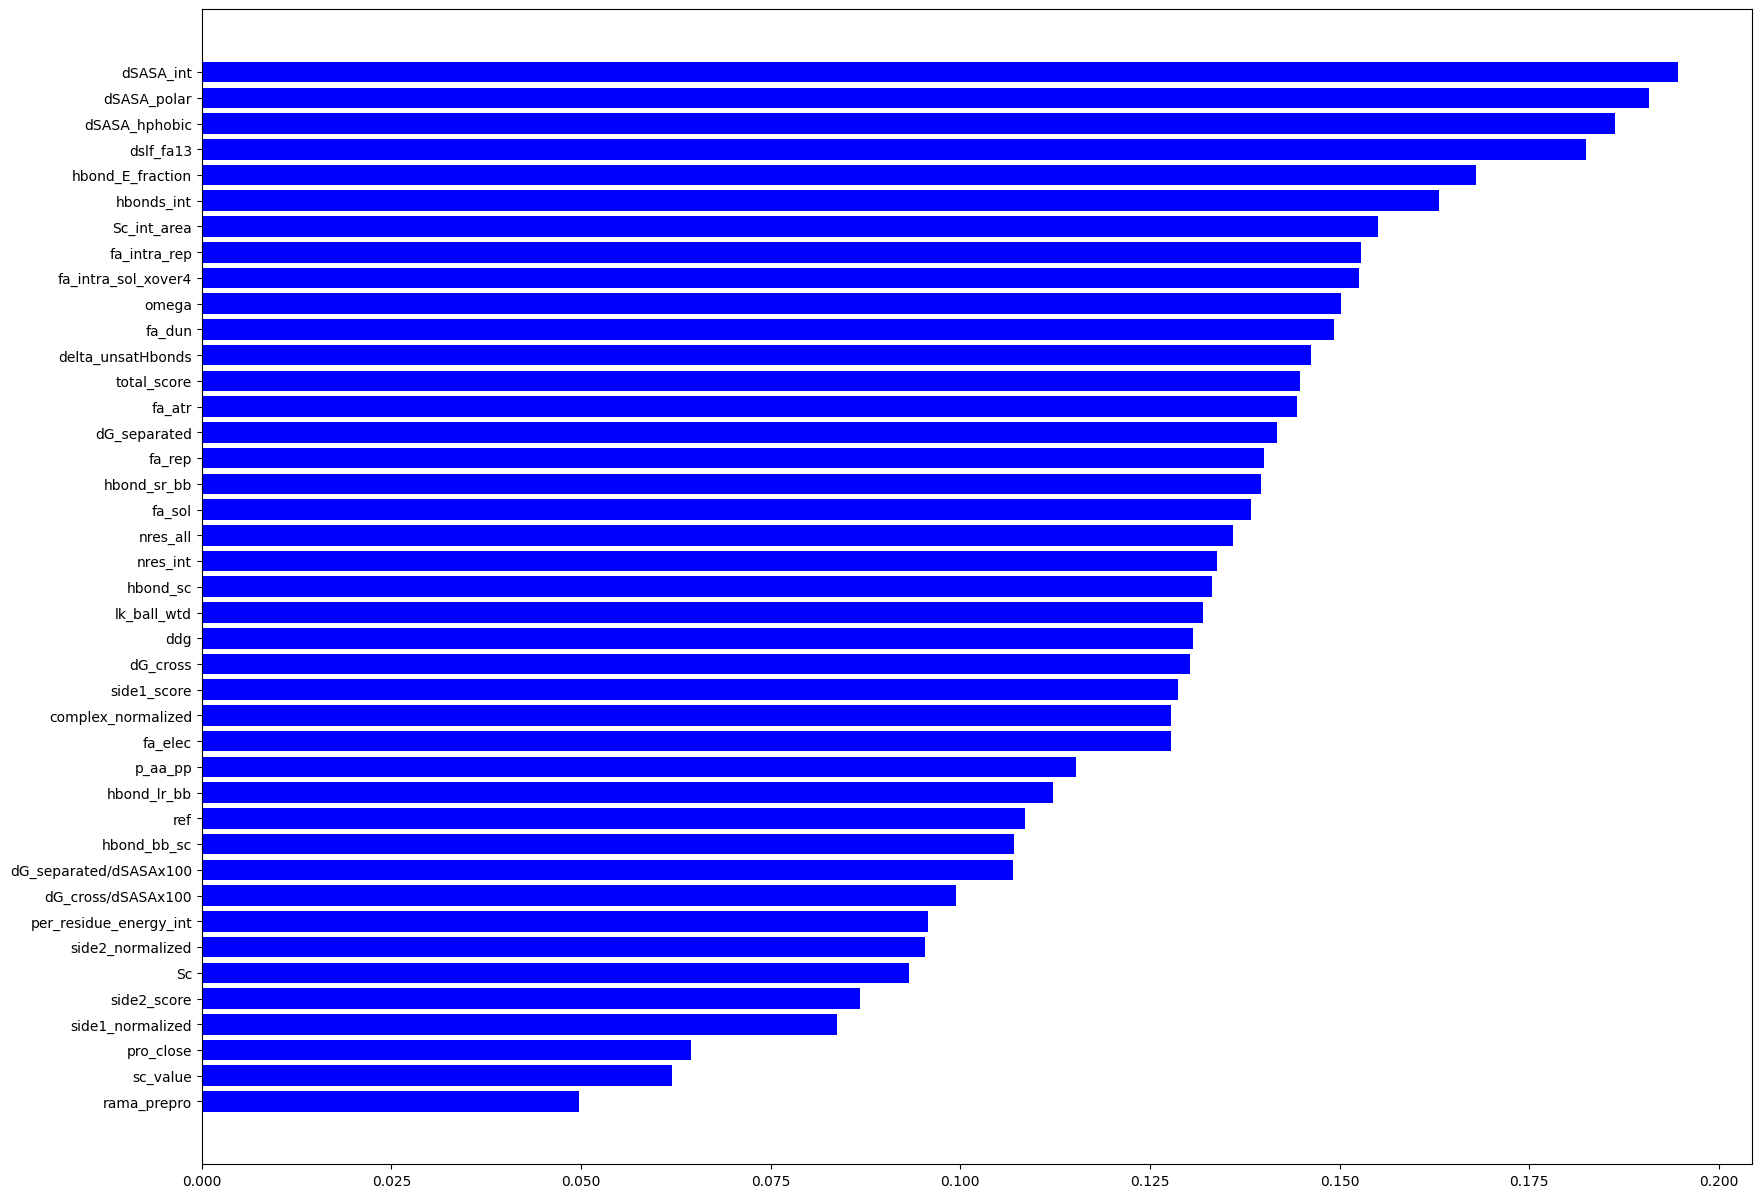

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




Metrics for Nanobody:
RMSE score: 1.9758
R2 score experimental vs ANN: -0.1680
Pearson correlation experimental vs ANN: 0.1095
Average prediction uncertainty: 0.1575

Results saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_48_PDBs_20250120_1636/Nanobody_comparison.csv
Feature importance saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_48_PDBs_20250120_1636/feature_importance_top_48_PDBs.csv


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




Metrics for PDBind:
RMSE score: 1.9474
R2 score experimental vs ANN: -0.0335
Pearson correlation experimental vs ANN: -0.0256
Average prediction uncertainty: 0.1112

Results saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_48_PDBs_20250120_1636/PDBind_comparison.csv
Feature importance saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_48_PDBs_20250120_1636/feature_importance_top_48_PDBs.csv


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Metrics for Nazmul:
RMSE score: 3.1059
R2 score experimental vs ANN: -0.0586
Pearson correlation experimental vs ANN: 0.1780
Average prediction uncertainty: 0.0623

Results saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_48_PDBs_20250120_1636/Nazmul_comparison.csv
Feature importance saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_48_PDBs_20250120_1636/feature_importance_top_48_PDBs.csv

Training with dataset: top_106_PDBs.csv


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model 0-0 trained


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model 0-1 trained
Shape of values[0]: (32, 15)


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



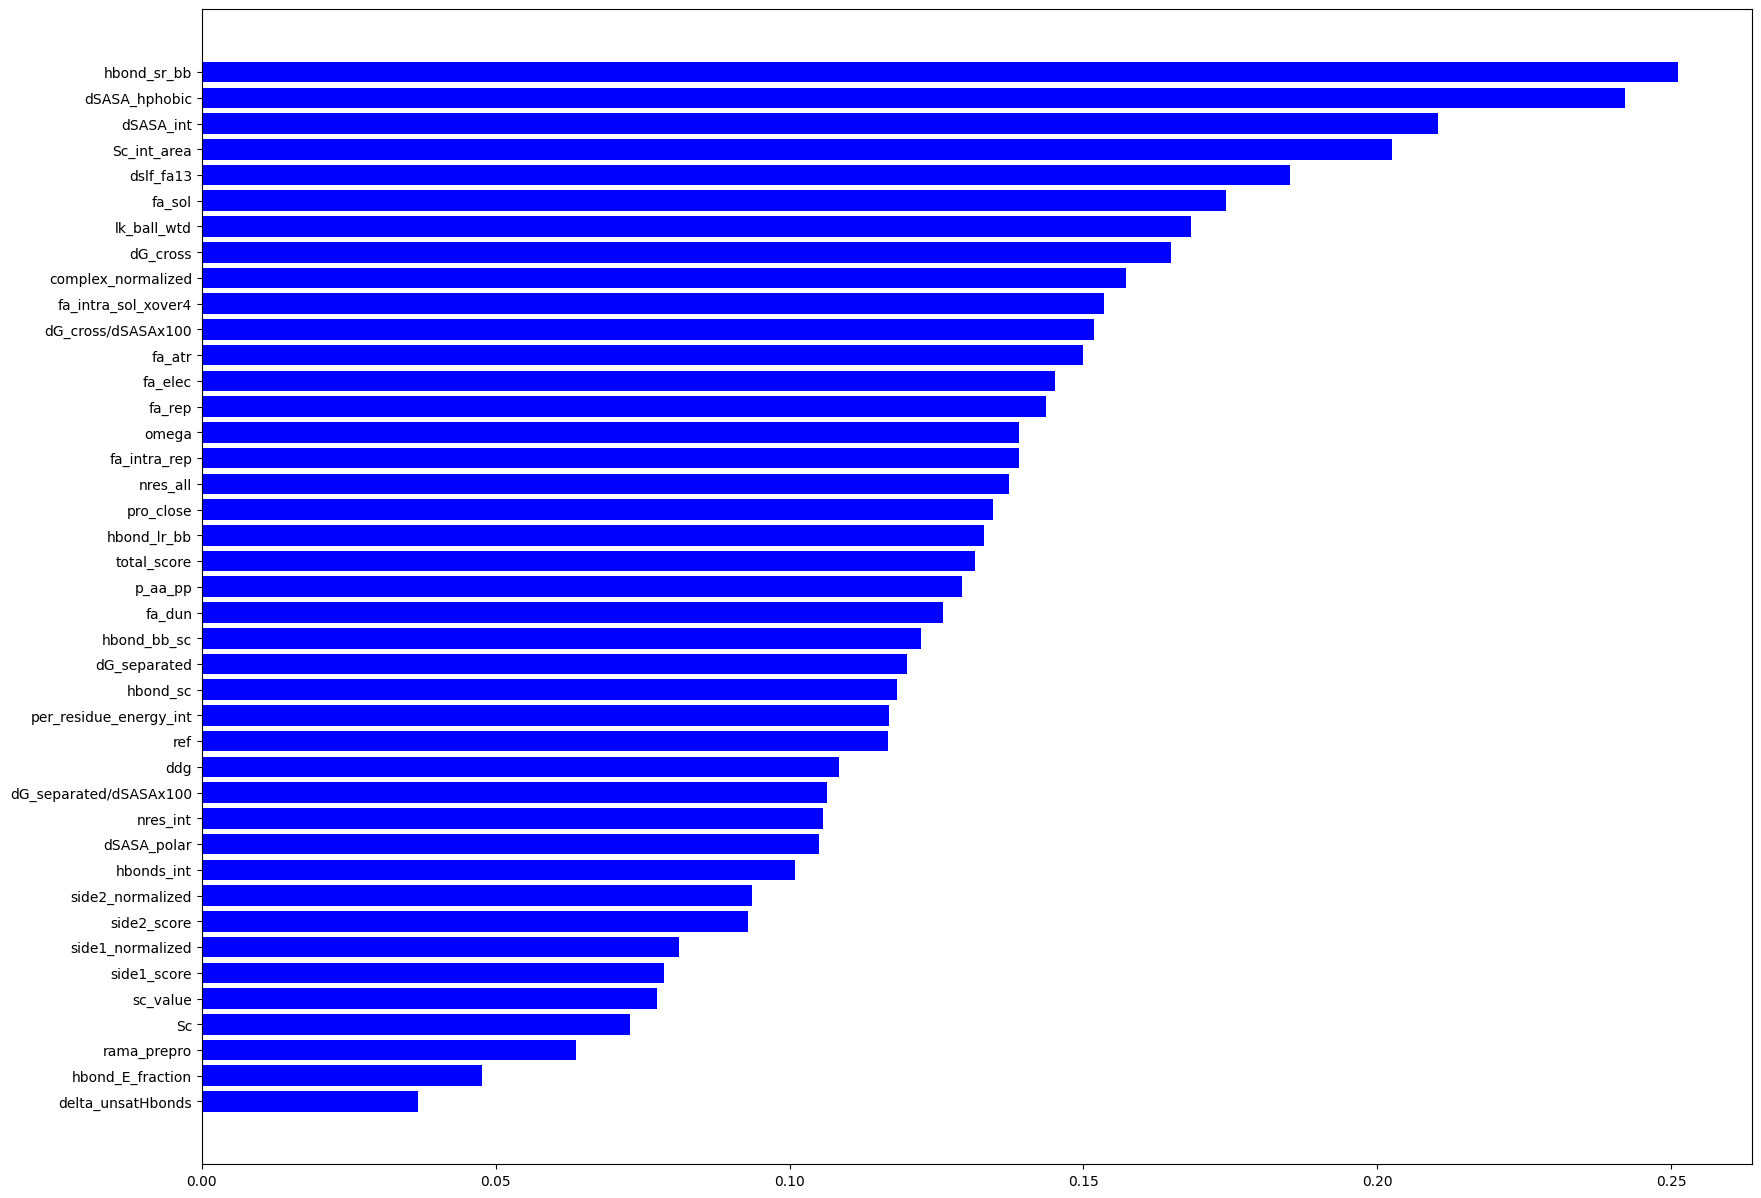


Metrics for Nanobody:
RMSE score: 2.3908
R2 score experimental vs ANN: -0.7101
Pearson correlation experimental vs ANN: -0.3349
Average prediction uncertainty: 0.0441

Results saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_106_PDBs_20250120_1636/Nanobody_comparison.csv
Feature importance saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_106_PDBs_20250120_1636/feature_importance_top_106_PDBs.csv


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




Metrics for PDBind:
RMSE score: 2.1436
R2 score experimental vs ANN: -0.2523
Pearson correlation experimental vs ANN: -0.0672
Average prediction uncertainty: 0.0413

Results saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_106_PDBs_20250120_1636/PDBind_comparison.csv
Feature importance saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_106_PDBs_20250120_1636/feature_importance_top_106_PDBs.csv


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Metrics for Nazmul:
RMSE score: 3.3025
R2 score experimental vs ANN: -0.1969
Pearson correlation experimental vs ANN: -0.0294
Average prediction uncertainty: 0.0486

Results saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_106_PDBs_20250120_1636/Nazmul_comparison.csv
Feature importance saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_106_PDBs_20250120_1636/feature_importance_top_106_PDBs.csv

Training with dataset: top_153_PDBs.csv


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model 0-0 trained


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model 0-1 trained
Shape of values[0]: (46, 15)


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



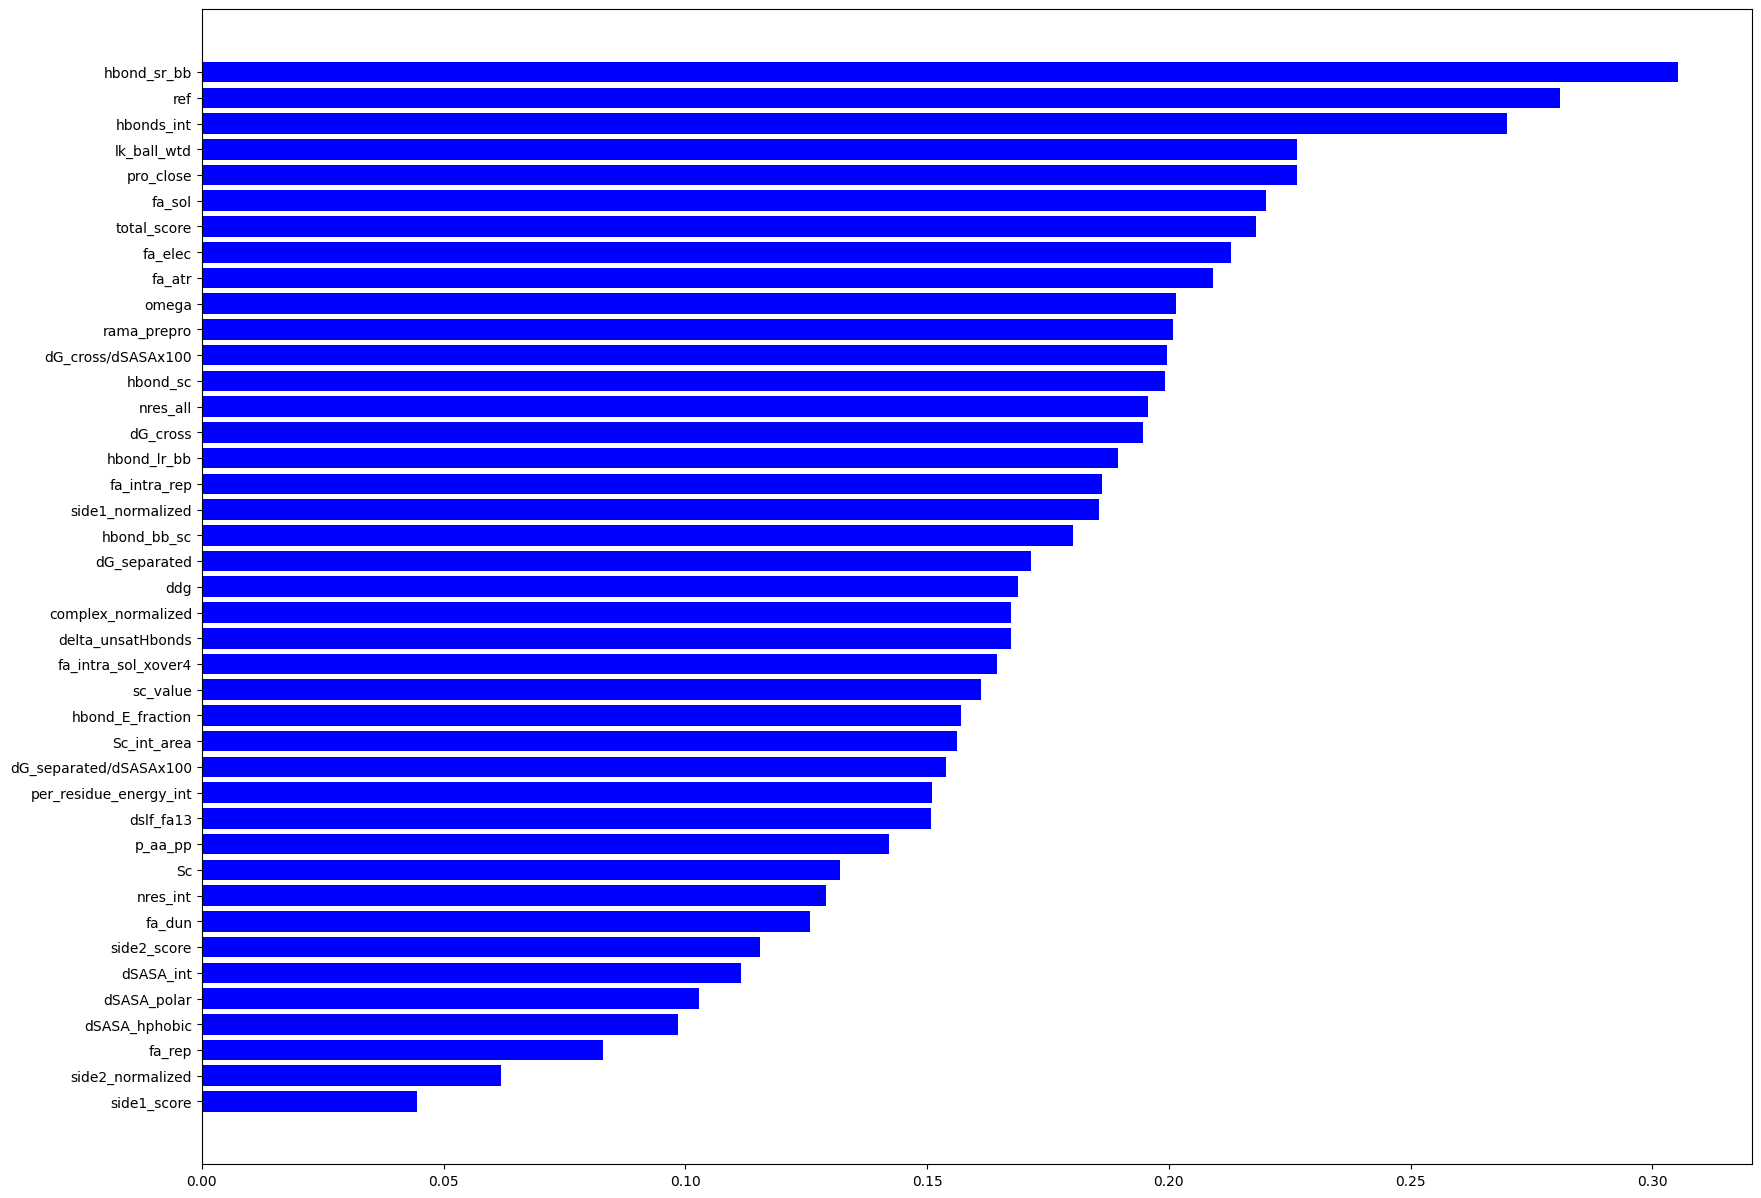

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




Metrics for Nanobody:
RMSE score: 2.0479
R2 score experimental vs ANN: -0.2548
Pearson correlation experimental vs ANN: -0.0033
Average prediction uncertainty: 0.0767

Results saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_153_PDBs_20250120_1637/Nanobody_comparison.csv
Feature importance saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_153_PDBs_20250120_1637/feature_importance_top_153_PDBs.csv


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




Metrics for PDBind:
RMSE score: 1.9341
R2 score experimental vs ANN: -0.0195
Pearson correlation experimental vs ANN: 0.0376
Average prediction uncertainty: 0.0570

Results saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_153_PDBs_20250120_1637/PDBind_comparison.csv
Feature importance saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_153_PDBs_20250120_1637/feature_importance_top_153_PDBs.csv

Metrics for Nazmul:
RMSE score: 3.0240
R2 score experimental vs ANN: -0.0036
Pearson correlation experimental vs ANN: 0.5121
Average prediction uncertainty: 0.0633

Results saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_153_PDBs_20250120_1637/Nazmul_comparison.csv
Feature importance saved to: /Users/qingshuzhao/Documents/machine learning PPI project/training_results/top_153_PDBs_20250120_1637/feature_importance_top_153_PDBs.csv
Total time taken: 94.77 seconds


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [2]:
def load_training_data(file_path, remove_anomalous=False):
    """Load and preprocess training data from a given file path"""
    df_energy = pd.read_csv(file_path)
    df_energy = df_energy.dropna().reset_index(drop=True)
    
    # Remove anomalous PDB entries if specified
    if remove_anomalous:
        anomaly_pdb_id = pd.read_csv("/Users/qingshuzhao/Documents/machine learning PPI project/anomaly_mapping.csv")
        df_energy = df_energy[~df_energy['pdb_id'].isin(anomaly_pdb_id['anomaly_id'])]
    
    # Add experimental binding energy
    df_energy['dG_exp'] = (1.98722*298.15*np.log(df_energy['kd_molar'])/1000)
    df_energy.drop(columns=['resolution', 'kd_molar'], axis=1, inplace=True)
    pdb_id = df_energy.pop('pdb_id')
    
    return df_energy


def get_predictions(X, models):
    """Get predictions from ensemble of models"""
    predictions = []
    for model in models:
        pred = model.predict(X, verbose=0)
        predictions.append(pred)
    predictions = np.array(predictions)
    mean_pred = np.mean(predictions, axis=0)
    std_pred = np.std(predictions, axis=0)
    return mean_pred.flatten(), std_pred.flatten()


def train_model(df_energy):
    """Train multiple neural network models on given data"""
    global X_train  # Make X_train global so it can be accessed by plot_shap_importance
    
    X = df_energy.drop(columns=['dG_exp'], axis=1)
    y = df_energy["dG_exp"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=seed_value,
                                                        shuffle=True)
    
    # Scale data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train),
                          index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),
                         index=X_test.index, columns=X_test.columns)
    
    # UMAP reduction and model training
    umap_dict = {}
    models_dict = {}
    
    for i in range(umap_limit):
        reducer = umap.UMAP(n_components=15, n_neighbors=20, random_state=42, transform_seed=42, verbose=False)

        X_t = reducer.fit_transform(X_train)
        X_t = pd.DataFrame(data=X_t, columns=[f"column_{i}" for i in range(X_t.shape[1])])

        X_te = reducer.transform(X_test)
        X_te = pd.DataFrame(data=X_te, columns=[f"column_{i}" for i in range(X_te.shape[1])])

        umap_dict[str(i)] = (X_t, X_te, reducer)

        # Train 10 models for ensemble
        models = []
        for j in range(2):
            model = keras.Sequential([
                layers.Dense(64, activation='relu', input_shape=(15,)),
                layers.Dense(32, activation='relu'),
                layers.Dense(16, activation='relu'),
                layers.Dense(1)
            ])
            
            model.compile(optimizer='adam', loss='mse')
            
            # Use K-fold validation
            kfold = KFold(n_splits=10, shuffle=True, random_state=seed_value)
            for train, val in kfold.split(X_t, y_train):
                history = model.fit(
                    X_t.iloc[train], y_train.iloc[train],
                    validation_data=(X_t.iloc[val], y_train.iloc[val]),
                    epochs=100,
                    batch_size=32,
                    verbose=0,
                    callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: float(lr * tf.math.exp(-0.1)) if epoch in [5, 50, 150] else lr)]
                )
            models.append(model)
            print(f"Model {i}-{j} trained")
            
        models_dict[str(i)] = models

    return models_dict, umap_dict, scaler


def evaluate_model(models_dict, umap_dict, scaler, test_data, dataset_name, training_file):
    """Evaluate ensemble model on test dataset"""
    metrics = {}
    
    global training_name, results_dir  # Make results_dir global
    # Create timestamped directory for this training run
    timestamp = time.strftime("%Y%m%d_%H%M")
    training_name = os.path.splitext(os.path.basename(training_file))[0]
    results_dir = f"/Users/qingshuzhao/Documents/machine learning PPI project/training_results/{training_name}_{timestamp}"
    os.makedirs(results_dir, exist_ok=True)

    for i in range(umap_limit):
        preds = []

        columns_to_drop = ['experimental', 'packstat', 'SCORE:', 'yhh_planarity', 'description']
        X_v = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns], axis=1).copy()
        y_v = test_data["experimental"].copy()
        
        X_v = pd.DataFrame(scaler.transform(X_v),
                        index=X_v.index, columns=X_v.columns)

        u = umap_dict[str(i)][2]
        X_v = u.transform(X_v)
        X_v = pd.DataFrame(data=X_v, columns=[f"column_{c}" for c in range(X_v.shape[1])])

        test_predictions, std = get_predictions(X_v, models_dict[str(i)])
        test = y_v.to_numpy()

        metrics['rmse'] = np.sqrt(mean_squared_error(test, test_predictions, squared=True))
        metrics['r2_ann'] = r2_score(test, test_predictions)
        metrics['pearson_ann'] = pearsonr(test, test_predictions)[0]

        print(f"\nMetrics for {dataset_name}:")
        print(f"RMSE score: {metrics['rmse']:.4f}")
        print(f"R2 score experimental vs ANN: {metrics['r2_ann']:.4f}")
        print(f"Pearson correlation experimental vs ANN: {metrics['pearson_ann']:.4f}")
        print(f"Average prediction uncertainty: {np.mean(std):.4f}")
     
        preds.append((test_predictions, test))

        df_comparison = pd.DataFrame({
            "REAL": test,
            "ANN_PREDICTED": test_predictions,
            "ANN_ERROR": test - test_predictions,
            "PREDICTION_STD": std,
            "PDB_ID": test_data['description'].values
        })

        output_path = os.path.join(results_dir, f"{dataset_name}_comparison.csv")
        df_comparison.to_csv(output_path, index=True)
        print(f"\nResults saved to: {output_path}")

    return metrics, results_dir


def plot_shap_importance(model, umap_dict, models_dict, n_models=1):
    # Get UMAP components
    components = umap_dict["0"][1].columns
    
    # Calculate SHAP values for each model
    shap_dict = {}
    shap_values_list = []
    
    for i in range(n_models):
        explainer = shap.DeepExplainer(models_dict[str(i)][0], umap_dict[str(i)][0].to_numpy())
        shap_values = explainer.shap_values(umap_dict[str(i)][1].to_numpy())
        if isinstance(shap_values, list):
            shap_values = np.sum(np.array(shap_values), axis=0)
        shap_values = np.squeeze(shap_values)
        shap_values_list.append(shap_values)
        
        print(f"Shape of values[{i}]: {shap_values_list[i].shape}")
        
        rf_resultX = pd.DataFrame(shap_values_list[i], columns=components)
        vals = np.abs(rf_resultX.values).mean(0)
        
        shap_importance = pd.DataFrame(list(zip(components, vals)),
                                     columns=['col_name','feature_importance_vals'])
        shap_importance.sort_values(by=['feature_importance_vals'],
                                  ascending=False, inplace=True)
        
        shap_dict[i] = shap_importance

    # Average SHAP values across models
    shap_df = shap_dict[0]
    for i in range(1, n_models):
        shap_df['feature_importance_vals'] += shap_dict[i]["feature_importance_vals"]
    shap_df['feature_importance_vals'] /= n_models

    # Get original features and correlations
    features = X_train.columns
    corr = pd.concat([X_train, umap_dict["0"][0]], axis=1).corr()

    # Calculate final feature importance values
    final_values = {}
    for f in features:
        s = .0
        for c in components:
            score = shap_df[shap_df["col_name"] == c]
            s += score["feature_importance_vals"].iloc[0] * abs(corr[f][c])
        final_values[f] = s

    # Sort values
    sorted_dict = {}
    sorted_keys = sorted(final_values, key=final_values.get, reverse=True)
    for w in sorted_keys:
        sorted_dict[w] = final_values[w]

    # Plot results
    plt.figure(figsize=(20, 15))
    plt.barh(list(sorted_dict.keys()), sorted_dict.values(), color='b')
    plt.gca().invert_yaxis()
    plt.show()
    
    return pd.DataFrame(list(sorted_dict.items()), columns=['Feature', 'Importance'])


def main():
    training_dir = "/Users/qingshuzhao/Documents/machine learning PPI project/training_dataset/new"
    
    nanobody_data = pd.read_csv("/Users/qingshuzhao/Documents/machine learning PPI project/testing_dataset/vhhs2_experimental.csv")
    pdbind_data = pd.read_csv("/Users/qingshuzhao/Documents/machine learning PPI project/testing_dataset/validation.csv")
    nazmul_data = pd.read_csv("/Users/qingshuzhao/Documents/machine learning PPI project/testing_dataset/Nazmul_11_scores_experimental.csv")
    
    results = []
    
    training_files = []
    for file_name in os.listdir(training_dir):
        if file_name.endswith('.csv'):
            file_path = os.path.join(training_dir, file_name)
            file_size = os.path.getsize(file_path)
            training_files.append((file_name, file_path, file_size))  # Store both name and path
    
    training_files.sort(key=lambda x: x[2])  # Sort by file size
    
    for file_name, file_path, _ in training_files:
        print(f"\nTraining with dataset: {file_name}")
        
        df_energy = load_training_data(file_path)
        models_dict, umap_dict, scaler = train_model(df_energy)
        
        # Generate SHAP importance plot for this model
        importance_df = plot_shap_importance(None, umap_dict, models_dict)
        
        test_datasets = {
            'Nanobody': nanobody_data,
            'PDBind': pdbind_data,
            'Nazmul': nazmul_data
        }
        
        for dataset_name, test_data in test_datasets.items():
            metrics, results_dir = evaluate_model(models_dict, umap_dict, scaler, test_data, dataset_name, file_path)
            
            # Save feature importance results after evaluate_model creates results_dir
            timestamp = time.strftime("%Y%m%d_%H%M")
            importance_path = os.path.join(results_dir, f"feature_importance_{os.path.splitext(file_name)[0]}.csv")
            importance_df.to_csv(importance_path)
            print(f"Feature importance saved to: {importance_path}")
            
            results.append({
                'training_file': file_name,
                'test_dataset': dataset_name,
                'metrics': metrics})

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"/Users/qingshuzhao/Documents/machine learning PPI project/training_results/metrics_{timestamp}.csv", index=False)

if __name__ == "__main__":
    import time
    start_time = time.time()
    main()
    end_time = time.time()
    print(f"Total time taken: {end_time - start_time:.2f} seconds")